In [1]:
import subprocess
import shlex
import re

import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")
TIMING_PATTERN = re.compile(r"\((\d+(?:\.\d+)?)s\)\.")

In [3]:
def test_exponential_inter_event_timing(
    mode, delta_t=1.0, lamda=0.5, seed=42, limit=100000000,
):
    factor = 10 ** abs(np.log10(lamda * delta_t))
    
    scaled_limit = int(limit / factor)
    
    output = subprocess.run(shlex.split(
        f"cargo run --release --quiet -- --delta-t {delta_t} --seed {seed} " +
        f"--lambda {lamda} --limit {scaled_limit} {CC_PATTERN.sub('-', mode).lower()}"
    ), check=True, capture_output=True, text=True).stdout
    
    return float(TIMING_PATTERN.search(output).group(1)) * limit / scaled_limit

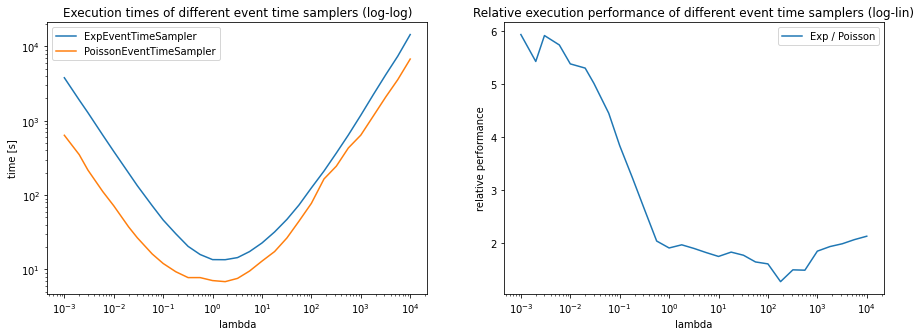

In [4]:
lambdas = [
    0.001, 0.002, 0.003, 0.006, 0.01, 0.02, 0.03, 0.06, 0.1, 0.18,
    0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10.0, 18.0, 32.0, 56.0, 100.0,
    180.0, 320.0, 560.0, 1000.0, 1800, 3200, 5600, 10000,
]
modes = ["Exponential", "Poisson"]

exp_times = [test_exponential_inter_event_timing("Exponential", lamda=lamda) for lamda in lambdas]
poi_times = [test_exponential_inter_event_timing("Poisson", lamda=lamda) for lamda in lambdas]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Execution times of different event time samplers (log-log)")
ax1.set_xlabel("lambda")
ax1.set_ylabel("time [s]")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.plot(lambdas, exp_times, label="ExpEventTimeSampler")
ax1.plot(lambdas, poi_times, label="PoissonEventTimeSampler")
ax1.legend()

ax2.set_title("Relative execution performance of different event time samplers (log-lin)")
ax2.set_xlabel("lambda")
ax2.set_ylabel("relative performance")
ax2.set_xscale("log")
ax2.plot(lambdas, [e / p for e, p in zip(exp_times, poi_times)], label="Exp / Poisson")
ax2.legend()

plt.show()